# Model

## Requirements

- import libraries

In [1]:
#!pip uninstall scikit-learn --yes
#!pip uninstall imblearn --yes
#!pip install scikit-learn==1.2.2
#!pip install imblearn

In [2]:
#%pip install folium branca
#%pip install lightgbm xgboost
#%pip install imblearn

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

- constant variables

- functions

In [4]:
from general_functions import data_validation, data_profiling, data_exploration
from ml_classification import *

## EDA

### Load Data

In [5]:
filename = "..\\data\\train.csv"
raw_df = pd.read_csv(filename)

raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### Data Profile

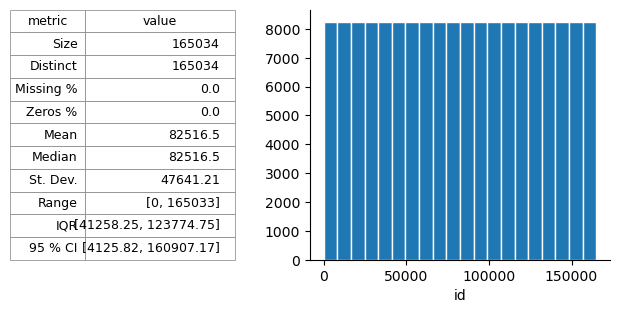

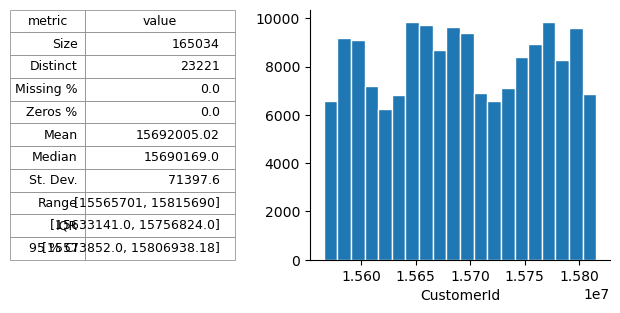

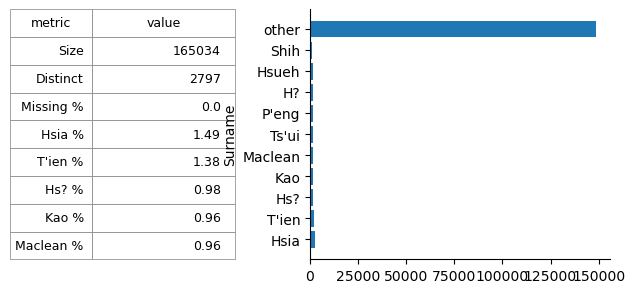

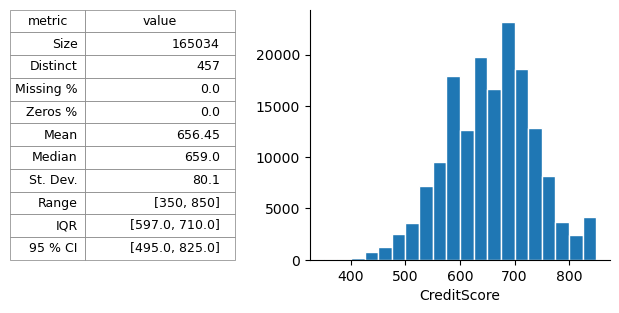

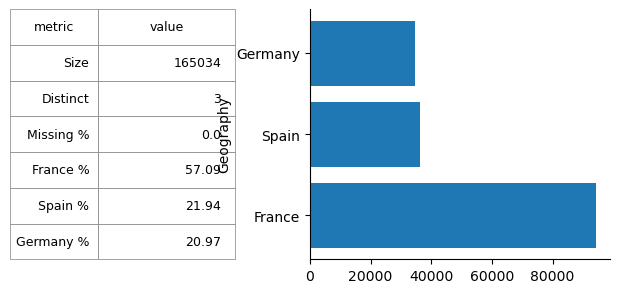

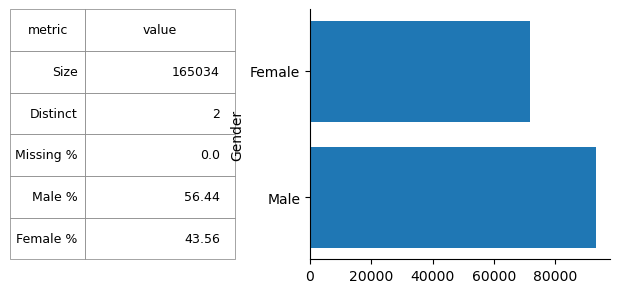

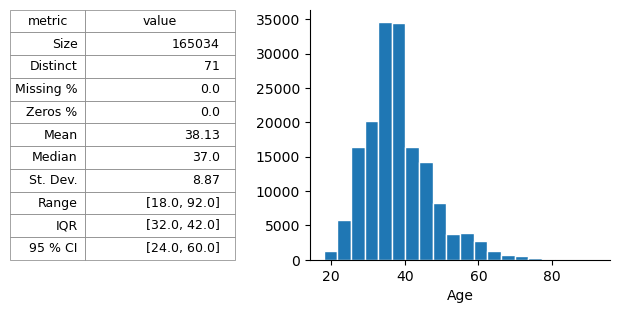

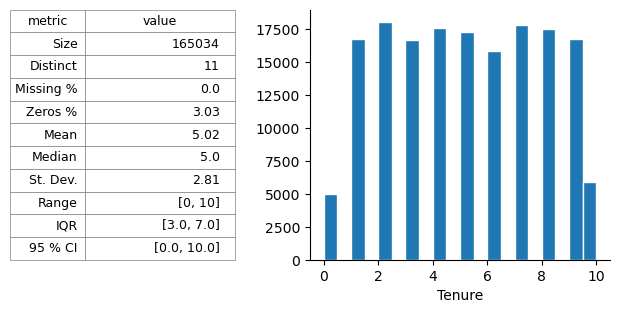

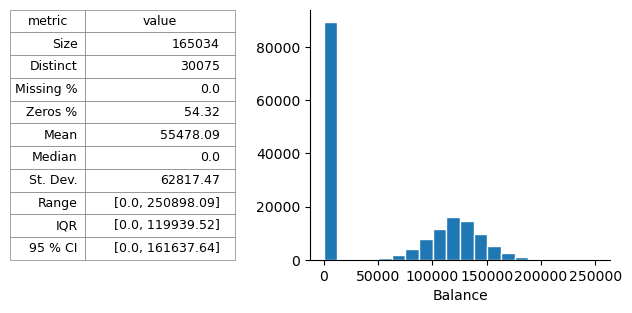

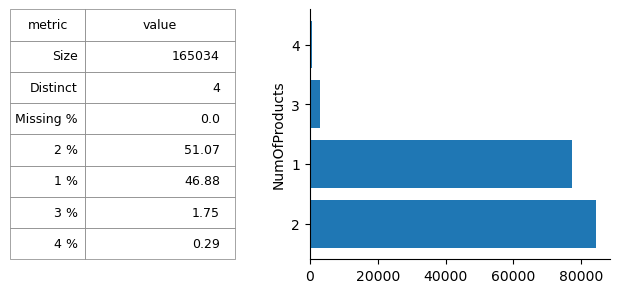

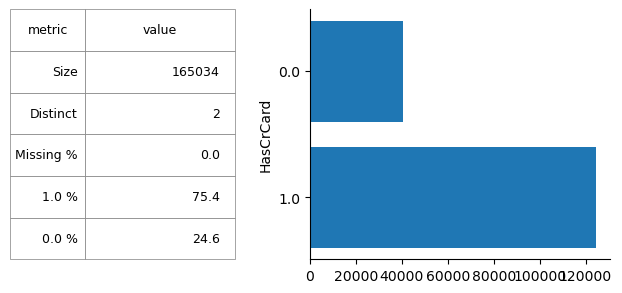

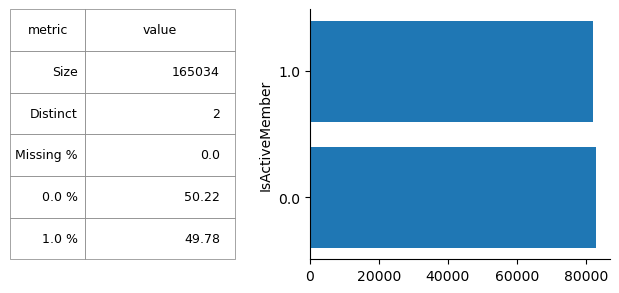

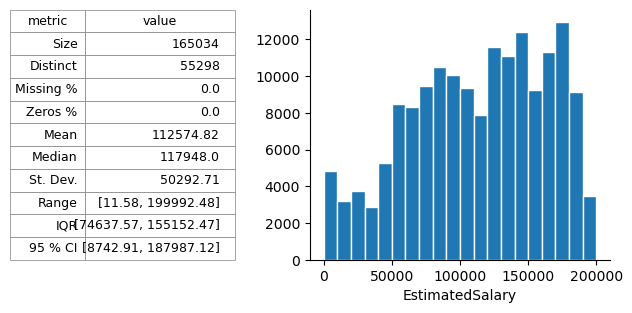

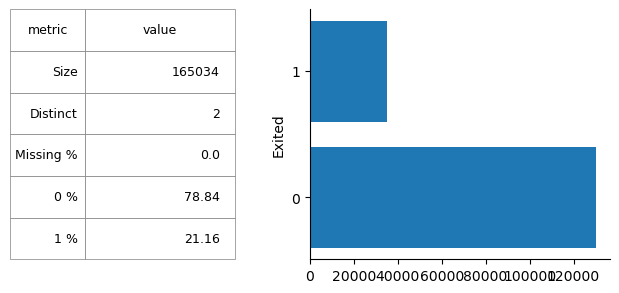

In [6]:
data_profiling.summarize_data(raw_df)

### XY correlations

c:\Users\mjafarikang\Documents\repo\Kaggle\notebooks\general_functions.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  elif pd.to_datetime(df[col], errors='coerce'
c:\Users\mjafarikang\Documents\repo\Kaggle\notebooks\general_functions.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  elif pd.to_datetime(df[col], errors='coerce'
c:\Users\mjafarikang\Documents\repo\Kaggle\notebooks\general_functions.py:50: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  elif pd.to_datetime(df[col], errors='coerce'


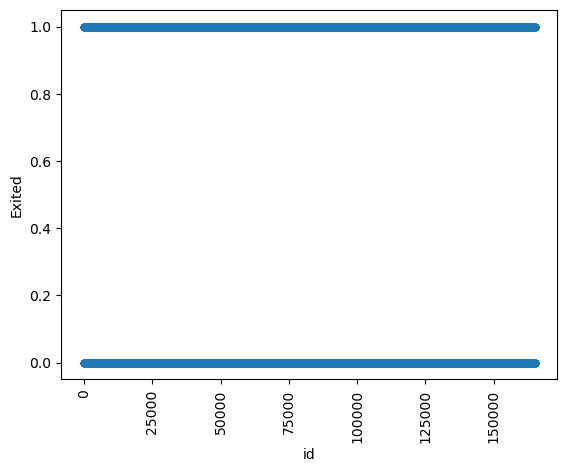

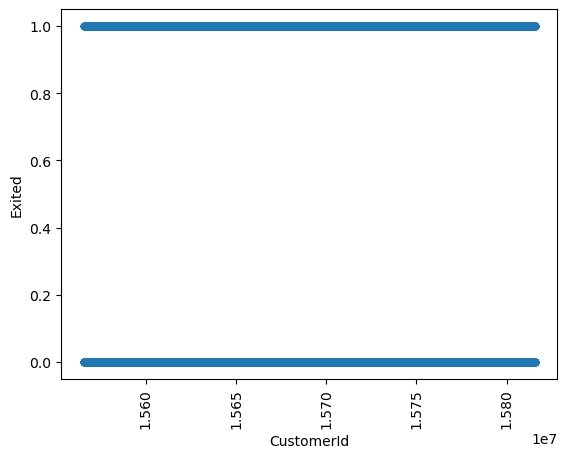

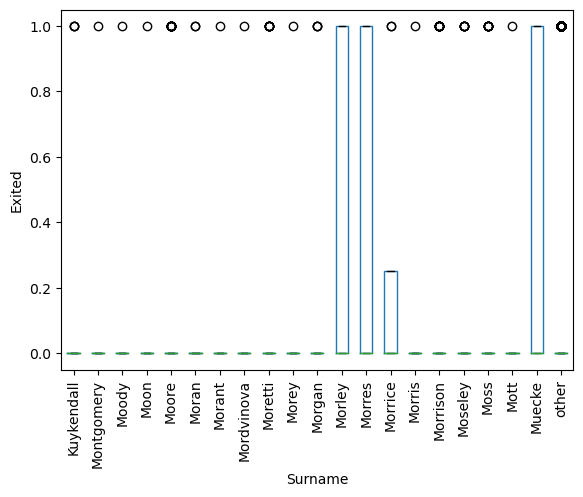

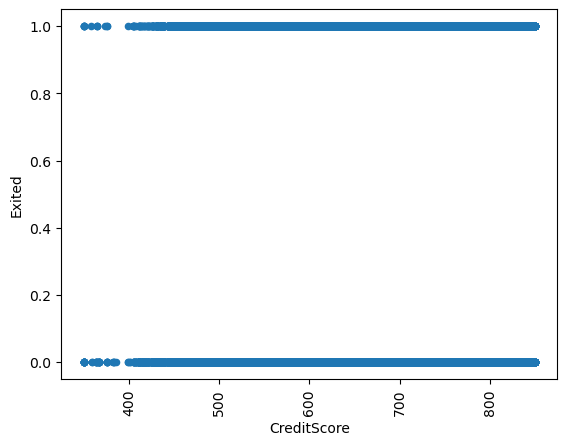

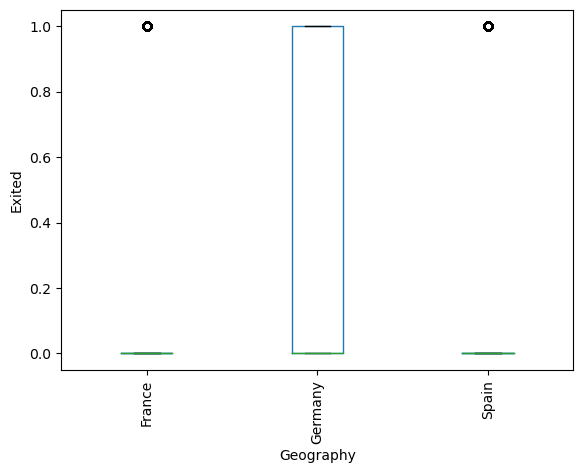

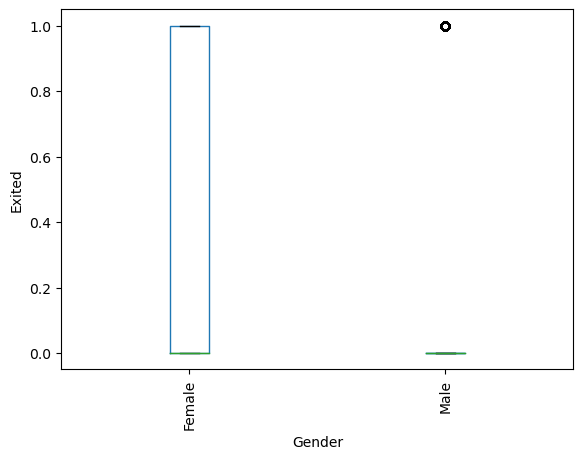

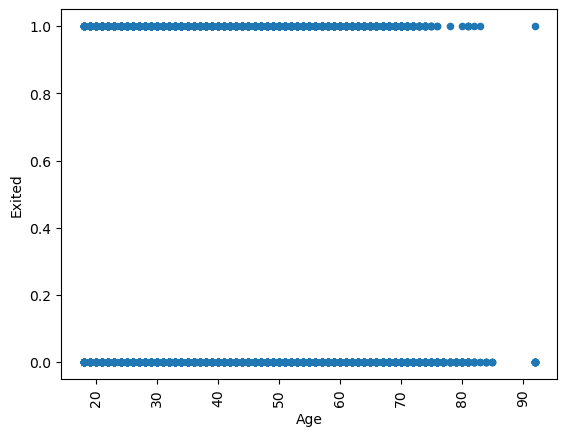

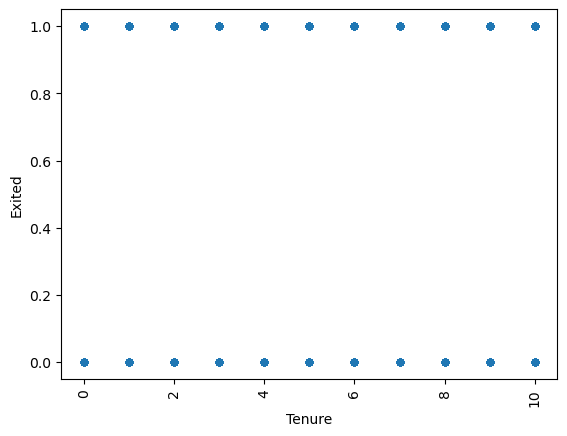

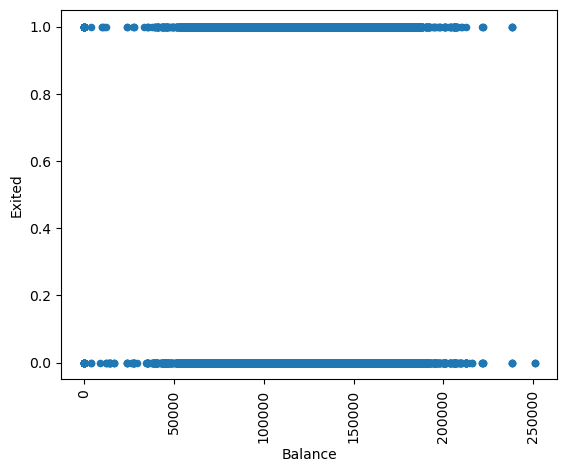

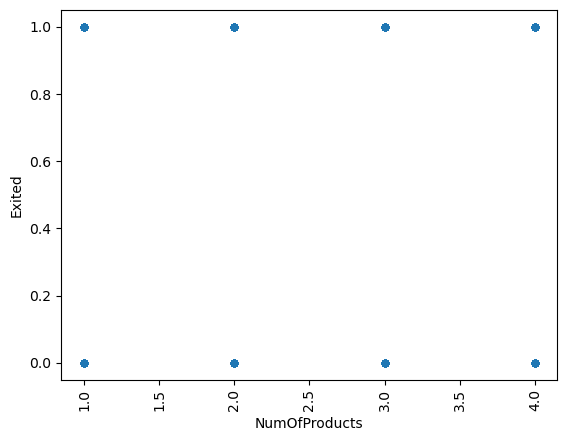

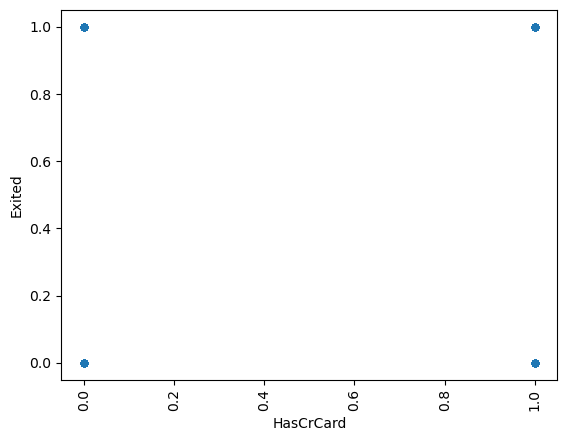

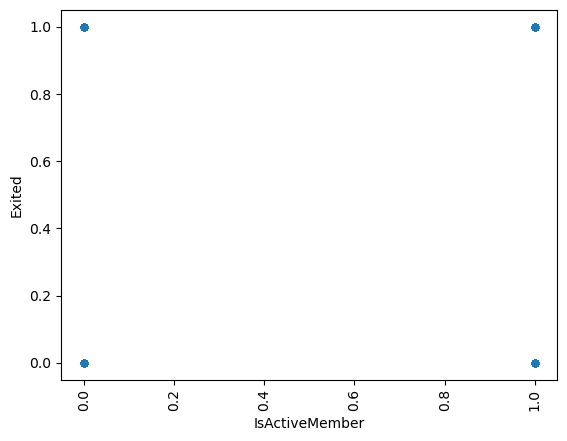

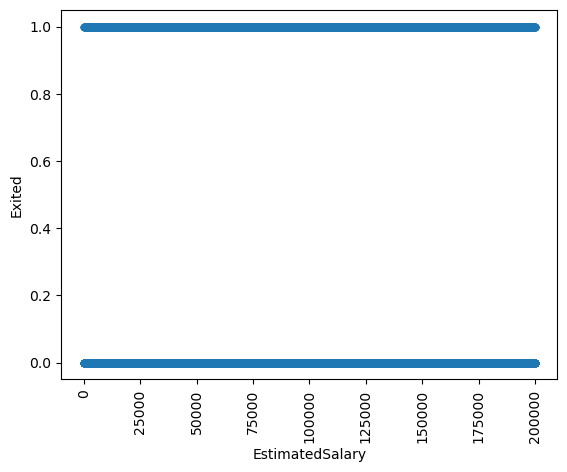

In [7]:
data_schema = data_validation.get_data_schema(raw_df)
target = 'Exited'
for key, value in data_schema.items():
    if key == target:
        continue
    if value == 'object':
        data_exploration.xy_boxplot(raw_df, key, target)
    else:
        data_exploration.xy_scatterplot(raw_df, key, target)

### Feature Engineering

In [8]:
pr_df = raw_df.copy()
pr_df.drop(['id', 'CustomerId'], axis=1, inplace=True)

- Customer names

In [9]:
import re

def clean_names(names):
    special_char = {
        'ß':'b', 
        'ã':'a', 
        'ä': 'a', 
        'è': 'e', 
        'é':'e', 
        'ë': 'e', 
        'ï':'i', 
        'ö':'o', 
        'ü':'u'
    }
    new_names = []
    max_length = 0
    for n in names:
        n = n.lower()
        for c,r in special_char.items():
            n = n.replace(c,r)
        a = re.sub('[^a-z]','',n)
        max_length = max(max_length, len(a))
        new_names.append(a)
    return new_names

def string_to_vector(array, max_length = 25):
    alphabet = {l:i+1 for i, l in enumerate(list('abcdefghijklmnopqrstuvwxyz'))}
    def converter(txt):
        if len(txt)>max_length:
            txt = txt[:max_length]
        vec = [0]*max_length
        for i, t in enumerate(list(txt.lower())):
            if t in alphabet:
                vec[i] = alphabet[t]
        
        return vec
    
    exp = []
    for txt in array:
        v = converter(txt)
        exp.append(v)

    return np.array(exp)

names = pr_df['Surname'].values
surnames = clean_names(names)
pr_df.drop('Surname', axis=1, inplace=True)
surname_vec = string_to_vector(surnames)


In [10]:
abrv_name = [name[:4] for name in names]
no_col = pr_df.shape[1]-1
pr_df.insert(no_col, 'abrv', abrv_name)

- Categorizing Credit Score

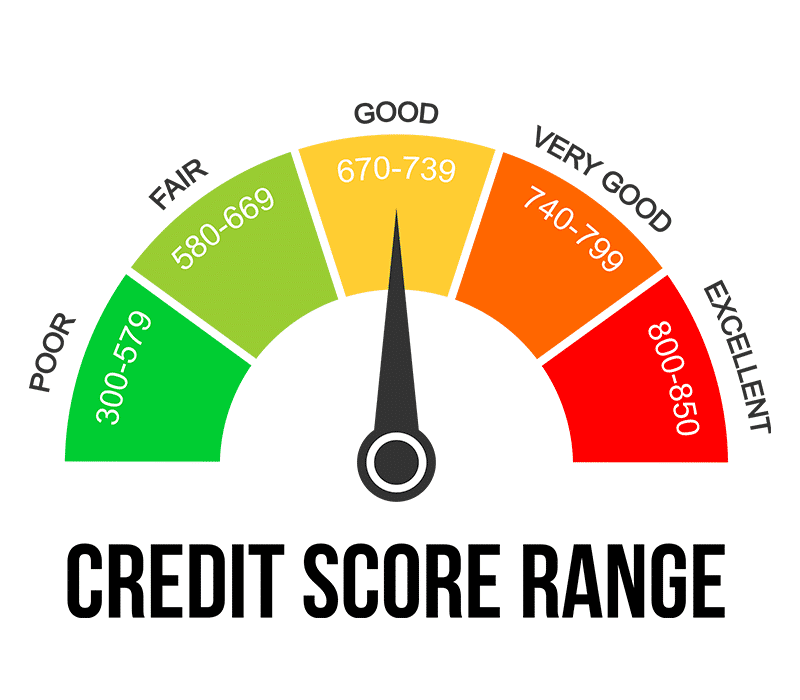

In [11]:
credit_range = {
    'Poor Credit': [300, 579],
    'Fair Credit': [580, 669],
    'Good Credit': [670, 739],
    'Very Good Credit': [740, 799],
    'Excellent Credit': [800, 850],
}
for key, val in credit_range.items():
    group = 1*((pr_df['CreditScore'].values>=val[0]) &
                 (pr_df['CreditScore'].values<=val[1]))
    no_col = pr_df.shape[1]-1
    pr_df.insert(no_col, key, group)

- Zero Balance

In [12]:
zeroBalance = 1*(pr_df['Balance']==0)

no_col = pr_df.shape[1]-1
pr_df.insert(no_col, 'zeroBalance', zeroBalance)

- Age buckets

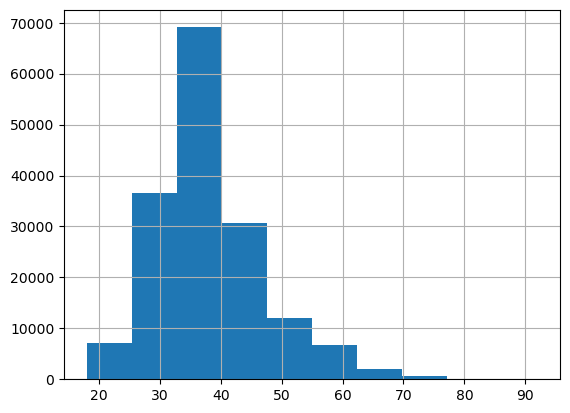

In [13]:
pr_df['Age'].hist()
age_range = {
    '20-25': [20, 25],
    '25-35': [25, 35],
    '35-65': [35, 65],
    '+65': [65, 100]
}
for key, val in age_range.items():
    group = 1*((pr_df['Age'].values>=val[0]) &
                 (pr_df['Age'].values<=val[1]))
    no_col = pr_df.shape[1]-1
    pr_df.insert(no_col, key, group)

- Salary Buckets

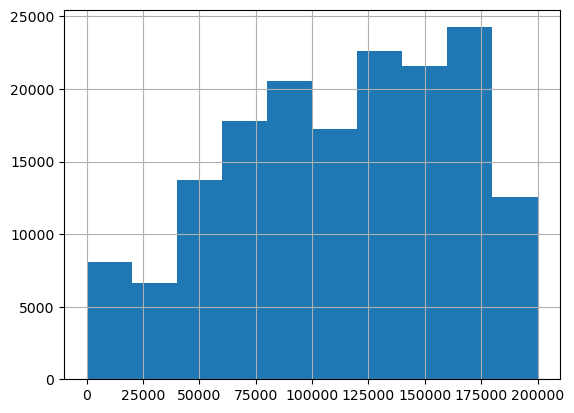

In [14]:
pr_df['EstimatedSalary'].hist()
salary_range = {
    '<20k': [0, 20000],
    '20k-50k': [20000, 50000],
    '50k-100k': [50000, 100000],
    '100k-150k': [100000, 150000],
    '150k+': [150000, 250000]

}
for key, val in salary_range.items():
    group = 1*((pr_df['EstimatedSalary'].values>=val[0]) &
                 (pr_df['EstimatedSalary'].values<=val[1]))
    no_col = pr_df.shape[1]-1
    pr_df.insert(no_col, key, group)

- encoder:
    - Geography
    - Gender
    - names

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

x = pr_df.iloc[:,:-1].values
y = pr_df.iloc[:,-1].values
columns = list(pr_df.columns)[:-1]

gender_en = LabelEncoder()
col_id = columns.index('Gender')
x[:,col_id] = gender_en.fit_transform(x[:,col_id])


encoded_features = ['Geography', 'abrv']

one_hat_columns = [columns.index(f) for f in encoded_features]
one_hat_encoder = ColumnTransformer(
        transformers= [
            ("one_hat_en", 
            OneHotEncoder(handle_unknown='ignore', sparse_output=False),
            one_hat_columns)
        ],
        remainder = 'passthrough'
        )
encoded_x = np.array(one_hat_encoder.fit_transform(x))

features =[]

for name in one_hat_encoder.get_feature_names_out():
    if 'x' not in name:
        continue
    f = name.split('x')[1]
    if '_' in f:
        n,v = f.split('_')
        n = int(n)
        f = "{}={}".format(columns[n],v)
    else:
        n = int(f)
        f = columns[n]
    features.append(f)
    print("{} -> {}".format(name, f))
ALL_FEATURES = features

#ALL_FEATURES += ['char {}'.format(i+1) for i in range(surname_vec.shape[1])] 
#encoded_x = np.column_stack((encoded_x,surname_vec))

one_hat_en__x1_France -> Geography=France
one_hat_en__x1_Germany -> Geography=Germany
one_hat_en__x1_Spain -> Geography=Spain
one_hat_en__x10_Abaz -> abrv=Abaz
one_hat_en__x10_Abbi -> abrv=Abbi
one_hat_en__x10_Abbo -> abrv=Abbo
one_hat_en__x10_Abdu -> abrv=Abdu
one_hat_en__x10_Abel -> abrv=Abel
one_hat_en__x10_Aber -> abrv=Aber
one_hat_en__x10_Abra -> abrv=Abra
one_hat_en__x10_Abre -> abrv=Abre
one_hat_en__x10_Abro -> abrv=Abro
one_hat_en__x10_Ache -> abrv=Ache
one_hat_en__x10_Adam -> abrv=Adam
one_hat_en__x10_Afam -> abrv=Afam
one_hat_en__x10_Afan -> abrv=Afan
one_hat_en__x10_Agaf -> abrv=Agaf
one_hat_en__x10_Agui -> abrv=Agui
one_hat_en__x10_Ah M -> abrv=Ah M
one_hat_en__x10_Aher -> abrv=Aher
one_hat_en__x10_Ahme -> abrv=Ahme
one_hat_en__x10_Aike -> abrv=Aike
one_hat_en__x10_Ains -> abrv=Ains
one_hat_en__x10_Aitk -> abrv=Aitk
one_hat_en__x10_Ajul -> abrv=Ajul
one_hat_en__x10_Akab -> abrv=Akab
one_hat_en__x10_Aker -> abrv=Aker
one_hat_en__x10_Akht -> abrv=Akht
one_hat_en__x10_Akob -> 

In [16]:
sc = MinMaxScaler()
x_scaled = sc.fit_transform(encoded_x)
x_copy = x_scaled.copy()
feature_copy = ALL_FEATURES.copy()
cols = [
 ['*', 'HasCrCard', 'IsActiveMember'],
 ['/', 'EstimatedSalary','Tenure'],
 ['/', 'NumOfProducts','Tenure'],
 ['*', 'zeroBalance','20-25'],
 ['*', 'Geography=Germany','Gender'],
 ['*', '20-25','Gender'],
]
for s, f1, f2 in cols:
        i = ALL_FEATURES.index(f1)
        j = ALL_FEATURES.index(f2)
        if s=='*':
                a = x_copy[:, i] * x_copy[:, j]
        else:
                a = x_copy[:, i] / (0.0001+x_copy[:, j])
        feature_copy.append("{}{}{}".format(f1, s, f2))
        x_copy = np.column_stack((x_copy, a))
print(x_copy.shape)


(165034, 2030)


- Feature Correlations

import seaborn as sns

copy_df = pd.DataFrame(x_copy.astype('float'),columns=feature_copy)
copy_df['Existed'] = y

corr = copy_df.corr().fillna(0)
fig,ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

is_lower_triangle = 1- np.triu(np.ones(corr.shape)).astype('bool')
df = corr.where(is_lower_triangle==1)
df = df.stack().reset_index()
df.columns = ['Row','Column','value']

df['value'] = np.abs(df['value'].values)
df.sort_values(by='value', ascending=False, inplace=True)

print("Top 20 highly correlated features:\n",
    df.head(20))

print("\nTop 20 features correlated to Y :\n",
    df.query('`Row`=="Existed"').head(20))

- Drop Correlated features

y_col = 'Exited'
threshold = 0.75

correlated_feautres = set()
seen_features = set()
for i, row in df.iterrows():
    if row['Row']== y_col or row['Column'] == y_col:
        continue

    if row['value']<threshold or \
        row['Row']== row['Column']:
        continue
    if row['Row'] in seen_features or\
        row['Column'] in seen_features:
         continue
    seen_features.add(row['Row'])
    seen_features.add(row['Column'])
    if  row['Row'] not in correlated_feautres:
        correlated_feautres.add(row['Column'])

is_correlated = []

for i,f in enumerate(feature_copy):
    if f not in correlated_feautres:
        is_correlated.append(i)
feature_copy = list(np.array(feature_copy)[is_correlated])
x_copy = x_copy[:,is_correlated]

- Feature Importance

TOP 30 important features
                       feature     score
2005             NumOfProducts  0.172326
2007            IsActiveMember  0.052501
2002                       Age  0.043856
2014               zeroBalance  0.032847
1            Geography=Germany  0.020437
2017                     35-65  0.011232
2001                    Gender  0.010813
1176                 abrv=McGr  0.008814
2024  HasCrCard*IsActiveMember  0.008453
1178                 abrv=McIn  0.007393
1383                 abrv=Onye  0.006874
2004                   Balance  0.006643
1301                  abrv=Niu  0.006623
1462                 abrv=Pisa  0.006411
1620                 abrv=Scot  0.006148
1141                 abrv=Mart  0.005955
1881                 abrv=Walk  0.005863
1590                 abrv=Sage  0.005801
1412                 abrv=Pale  0.005683
1076                 abrv=Lomb  0.005679
1134                  abrv=Mao  0.005621
984                    abrv=Ku  0.005532
28                   abrv=Akob 

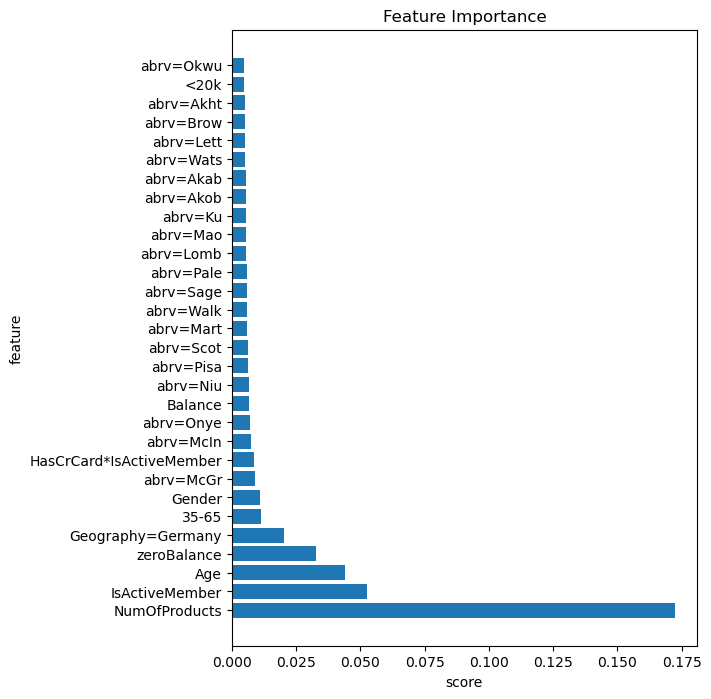

In [17]:
im_df = feature_importance(x_copy, y, feature_copy, is_classifer=True, top_k=30)

- Drop un-important features

In [18]:
unimportant_feautres= im_df.query('score < 0.002')['feature'].values

is_important = []

for i,f in enumerate(feature_copy):
    if f not in unimportant_feautres:
        is_important.append(i)
feature_copy = list(np.array(feature_copy)[is_important])
x_copy = x_copy[:,is_important]
x_copy.shape

(165034, 135)

## Model Development

In [19]:
x_train, x_test, y_train, y_test = train_test_split(
    x_copy, y, test_size=0.3, random_state=123
)
print(x_train.shape, y_train.shape)


(115523, 135) (115523,)


In [20]:
sample_x, sample_y = x_train[:1000], y_train[:1000]
base_model = compare_models(sample_x, sample_y)

lr	Accuracy: 0.84	AUC: 0.66	Recall: 0.84	Precision: 0.82	F1-Score: 0.82	Kappa: 0.39	MCC: 0.42	Log Loss: 0.38	Training Time: 0.01	
knn	Accuracy: 0.86	AUC: 0.71	Recall: 0.86	Precision: 0.85	F1-Score: 0.84	Kappa: 0.48	MCC: 0.50	Log Loss: 2.25	Training Time: 0.00	
nb	Accuracy: 0.29	AUC: 0.51	Recall: 0.29	Precision: 0.71	F1-Score: 0.26	Kappa: 0.01	MCC: 0.03	Log Loss: 25.48	Training Time: 0.00	
dt	Accuracy: 0.82	AUC: 0.72	Recall: 0.82	Precision: 0.82	F1-Score: 0.82	Kappa: 0.43	MCC: 0.43	Log Loss: 6.46	Training Time: 0.01	
svm	Accuracy: 0.80	AUC: 0.50	Recall: 0.80	Precision: 0.64	F1-Score: 0.71	Kappa: 0.00	MCC: 0.00	Log Loss: 0.39	Training Time: 0.08	
rbfsvm	Accuracy: 0.82	AUC: 0.61	Recall: 0.82	Precision: 0.79	F1-Score: 0.79	Kappa: 0.29	MCC: 0.32	Log Loss: 0.43	Training Time: 0.16	
mlp	Accuracy: 0.84	AUC: 0.70	Recall: 0.84	Precision: 0.83	F1-Score: 0.83	Kappa: 0.45	MCC: 0.46	Log Loss: 0.44	Training Time: 0.49	
rf	Accuracy: 0.85	AUC: 0.72	Recall: 0.85	Precision: 0.84	F1-Score: 0.84	Kappa: 0.4

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,Log Loss,Training Time
10,gbc,0.865000,0.741584,0.865000,0.857831,0.856333,0.533079,0.545568,0.338256,0.143771
12,et,0.850000,0.741232,0.850000,0.844363,0.845349,0.508044,0.512447,1.472745,0.143879
9,ada,0.851000,0.732734,0.851000,0.842581,0.844270,0.499565,0.505475,0.660246,0.084484
13,xgboost,0.844000,0.735607,0.844000,0.837893,0.839606,0.490563,0.493611,0.470368,0.037484
7,rf,0.850000,0.718877,0.850000,0.840062,0.840596,0.482083,0.492489,0.607421,0.146835
1,knn,0.856000,0.711751,0.856000,0.846110,0.842650,0.481859,0.501481,2.254533,0.000200
14,lgbm,0.839000,0.721358,0.839000,0.830842,0.833208,0.467051,0.470873,0.438508,0.040696
6,mlp,0.841000,0.698675,0.841000,0.827691,0.830002,0.445112,0.455017,0.442536,0.486889
3,dt,0.819000,0.716165,0.819000,0.818435,0.817562,0.431558,0.434058,6.462159,0.006249
0,lr,0.838000,0.661992,0.838000,0.822465,0.816268,0.386358,0.415851,0.383243,0.009445



*******
Results for model GradientBoostingClassifier(random_state=123):



,metrics,train,validation
0,Accuracy,0.87,0.86
1,AUC,0.74,0.74
2,Recall,0.87,0.86
3,Precision,0.86,0.86
4,F1-Score,0.86,0.85
5,Kappa,0.54,0.54
6,MCC,0.56,0.56
7,Log Loss,0.32,0.32
8,Training Time,53.54,53.54


              precision    recall  f1-score   support

           0       0.88      0.96      0.92     38922
           1       0.77      0.52      0.62     10589

    accuracy                           0.86     49511
   macro avg       0.83      0.74      0.77     49511
weighted avg       0.86      0.86      0.85     49511



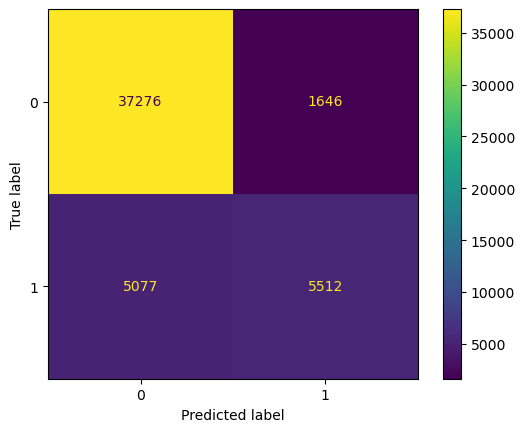

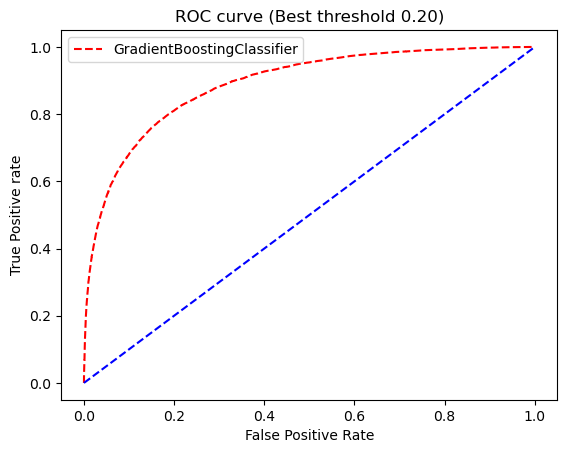

In [21]:
base_model,_ = train_a_model(x_train, y_train, x_test, y_test, base_model)

model_evaluation(base_model, x_test, y_test)

- Oversampling

In [22]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE(random_state=123, sampling_strategy=1)

sample_x, sample_y = x_train[:1000], y_train[:1000]
sample_x, sample_y = sampler.fit_resample(sample_x, sample_y)
base_model_over = compare_models(sample_x, sample_y)

lr	Accuracy: 0.79	AUC: 0.79	Recall: 0.79	Precision: 0.79	F1-Score: 0.79	Kappa: 0.58	MCC: 0.58	Log Loss: 0.45	Training Time: 0.01	
knn	Accuracy: 0.85	AUC: 0.85	Recall: 0.85	Precision: 0.85	F1-Score: 0.85	Kappa: 0.70	MCC: 0.70	Log Loss: 1.56	Training Time: 0.00	
nb	Accuracy: 0.56	AUC: 0.56	Recall: 0.56	Precision: 0.72	F1-Score: 0.46	Kappa: 0.12	MCC: 0.23	Log Loss: 15.77	Training Time: 0.00	
dt	Accuracy: 0.85	AUC: 0.85	Recall: 0.85	Precision: 0.85	F1-Score: 0.85	Kappa: 0.70	MCC: 0.70	Log Loss: 5.27	Training Time: 0.01	
svm	Accuracy: 0.77	AUC: 0.77	Recall: 0.77	Precision: 0.77	F1-Score: 0.77	Kappa: 0.54	MCC: 0.55	Log Loss: 0.48	Training Time: 0.27	
rbfsvm	Accuracy: 0.87	AUC: 0.87	Recall: 0.87	Precision: 0.87	F1-Score: 0.87	Kappa: 0.74	MCC: 0.74	Log Loss: 0.37	Training Time: 0.38	
mlp	Accuracy: 0.85	AUC: 0.85	Recall: 0.85	Precision: 0.85	F1-Score: 0.85	Kappa: 0.70	MCC: 0.71	Log Loss: 0.38	Training Time: 0.89	
rf	Accuracy: 0.90	AUC: 0.90	Recall: 0.90	Precision: 0.90	F1-Score: 0.90	Kappa: 0.7

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,Log Loss,Training Time
12,et,0.897862,0.897862,0.897862,0.899681,0.897754,0.795725,0.797538,0.529077,0.193134
7,rf,0.896614,0.896604,0.896614,0.897690,0.896562,0.793229,0.794302,0.338727,0.187564
13,xgboost,0.890357,0.890358,0.890357,0.891325,0.890304,0.780717,0.781682,0.311281,0.049891
10,gbc,0.887857,0.887858,0.887857,0.889149,0.887760,0.775715,0.777004,0.299439,0.234218
14,lgbm,0.887853,0.887873,0.887853,0.888753,0.887801,0.775718,0.776610,0.304458,0.064953
5,rbfsvm,0.868427,0.868424,0.868427,0.869326,0.868353,0.736849,0.737748,0.369134,0.378193
9,ada,0.859647,0.859611,0.859647,0.860622,0.859558,0.719275,0.720257,0.663793,0.109220
6,mlp,0.852122,0.852119,0.852122,0.854849,0.851863,0.704243,0.706959,0.376515,0.887408
1,knn,0.850872,0.850818,0.850872,0.852813,0.850652,0.701708,0.703657,1.556809,0.000000
3,dt,0.850889,0.850873,0.850889,0.851691,0.850800,0.701769,0.702574,5.271122,0.006227



*******
Results for model ExtraTreesClassifier(random_state=123):



,metrics,train,validation
0,Accuracy,0.95,0.81
1,AUC,0.95,0.75
2,Recall,0.95,0.81
3,Precision,0.95,0.82
4,F1-Score,0.95,0.82
5,Kappa,0.91,0.48
6,MCC,0.91,0.48
7,Log Loss,0.10,1.53
8,Training Time,88.71,88.71


              precision    recall  f1-score   support

           0       0.90      0.86      0.88     38922
           1       0.56      0.64      0.60     10589

    accuracy                           0.81     49511
   macro avg       0.73      0.75      0.74     49511
weighted avg       0.82      0.81      0.82     49511



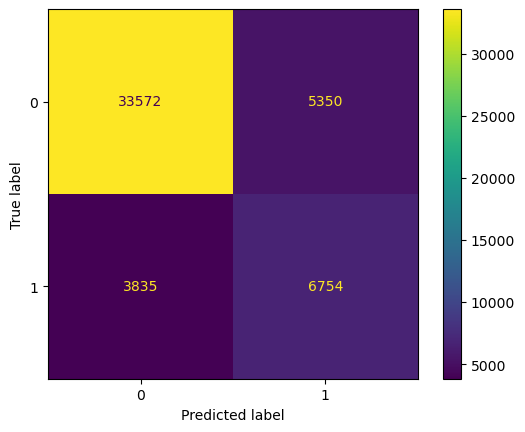

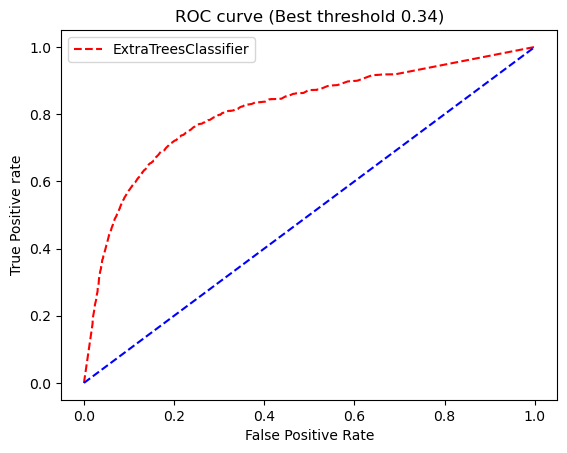

In [24]:
x_over, y_over = sampler.fit_resample(x_train, y_train)
base_model_over,_ = train_a_model(x_over, y_over, x_test, y_test, base_model_over)

model_evaluation(base_model_over, x_test, y_test)

In [25]:
tuned_rf, rf_param = tune_a_classifier('rf', sample_x, sample_y)
tuned_lgb, lgb_param = tune_a_classifier('lgbm', sample_x, sample_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'gini', 'class_weight': 'balanced_subsample', 'bootstrap': True}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 504, number of negative: 496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 481
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 12
[Light

In [26]:
lgb_param_2 = {
    "objective": "binary",
    "metric": "auc",
    "device": "gpu",
    "boosting": "goss",
    "learning_rate": 0.018,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "lambda_l1": 1.1214323077269823,
    "lambda_l2": 0.005114020277529055,
    "n_jobs": -1,
    "is_unbalance": True,
    "verbose": -1,
    "seed": 42,
}

tuned_lgb2 = LGBMClassifier(**lgb_param_2)



*******
Results for model LGBMClassifier(boosting_type='dart', colsample_bytree=0.8, learning_rate=0.2,
               max_depth=5, min_split_gain=0.1, n_estimators=300, num_leaves=15,
               random_state=123, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9):



,metrics,train,validation
0,Accuracy,0.85,0.83
1,AUC,0.85,0.80
2,Recall,0.85,0.83
3,Precision,0.85,0.85
4,F1-Score,0.85,0.84
5,Kappa,0.69,0.54
6,MCC,0.69,0.55
7,Log Loss,0.36,0.39
8,Training Time,9.04,9.04


              precision    recall  f1-score   support

           0       0.92      0.86      0.89     38922
           1       0.58      0.74      0.65     10589

    accuracy                           0.83     49511
   macro avg       0.75      0.80      0.77     49511
weighted avg       0.85      0.83      0.84     49511



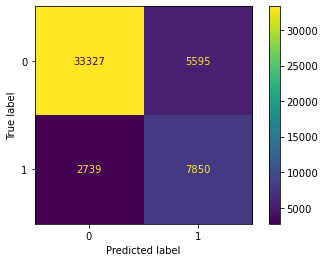

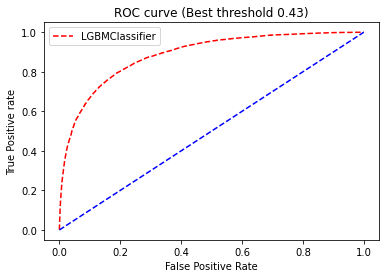

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.1214323077269823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1214323077269823
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005114020277529055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005114020277529055

*******
Results for model LGBMClassifier(bagging_fraction=0.5, boosting='goss', device='gpu',
               feature_fraction=0.5, is_unbalance=True,
               lambda_l1=1.1214323077269823, lambda_l2=0.005114020277529055,
               learning_rate=0.018, metric='auc', objective='binary', seed=42,
               verbose=-1):



,metrics,train,validation
0,Accuracy,0.82,0.82
1,AUC,0.82,0.80
2,Recall,0.82,0.82
3,Precision,0.82,0.85
4,F1-Score,0.82,0.83
5,Kappa,0.65,0.52
6,MCC,0.65,0.54
7,Log Loss,0.44,0.45
8,Training Time,4.46,4.46


              precision    recall  f1-score   support

           0       0.93      0.83      0.88     38922
           1       0.55      0.76      0.64     10589

    accuracy                           0.82     49511
   macro avg       0.74      0.80      0.76     49511
weighted avg       0.85      0.82      0.83     49511



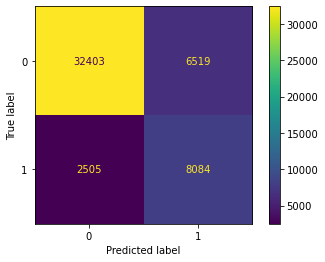

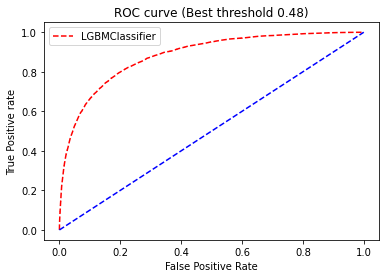

In [ ]:
x_over, y_over = sampler.fit_resample(x_train, y_train)

tuned_rf,_ = train_a_model(x_over, y_over, x_test, y_test, tuned_rf)
model_evaluation(tuned_rf, x_test, y_test)

tuned_lgb,_ = train_a_model(x_over, y_over, x_test, y_test, tuned_lgb)
model_evaluation(tuned_lgb, x_test, y_test)

tuned_lgb2,_ = train_a_model(x_over, y_over, x_test, y_test, tuned_lgb2)
model_evaluation(tuned_lgb2, x_test, y_test)

In [29]:
im_df = pd.DataFrame(
    {"feature": feature_copy, "score": tuned_lgb2.feature_importances_}
).sort_values(by="score", ascending=False)

display(im_df.head(50))

top_20_feature = im_df.head(50)["feature"].values
ids = np.where(np.in1d(feature_copy, top_20_feature))[0]
top_x_over = x_over[:, ids]
top_x_test = x_test[:, ids]
top_sample_x = sample_x[:, ids]

,feature,score
127,Age,968
128,Balance,368
129,NumOfProducts,293
126,Gender,217
130,IsActiveMember,198
134,HasCrCard*IsActiveMember,123
0,Geography=Germany,119
131,zeroBalance,79
132,35-65,48
86,abrv=Onye,41



*******
Results for model LGBMClassifier(bagging_fraction=0.5, boosting='goss', device='gpu',
               feature_fraction=0.5, is_unbalance=True,
               lambda_l1=1.1214323077269823, lambda_l2=0.005114020277529055,
               learning_rate=0.018, metric='auc', n_jobs=-1, objective='binary',
               seed=42, verbose=-1):



,metrics,train,validation
0,Accuracy,0.83,0.82
1,AUC,0.83,0.80
2,Recall,0.83,0.82
3,Precision,0.83,0.85
4,F1-Score,0.83,0.83
5,Kappa,0.65,0.53
6,MCC,0.65,0.54
7,Log Loss,0.45,0.46
8,Training Time,1.95,1.95


              precision    recall  f1-score   support

           0       0.93      0.83      0.88     38922
           1       0.55      0.78      0.65     10589

    accuracy                           0.82     49511
   macro avg       0.74      0.80      0.76     49511
weighted avg       0.85      0.82      0.83     49511



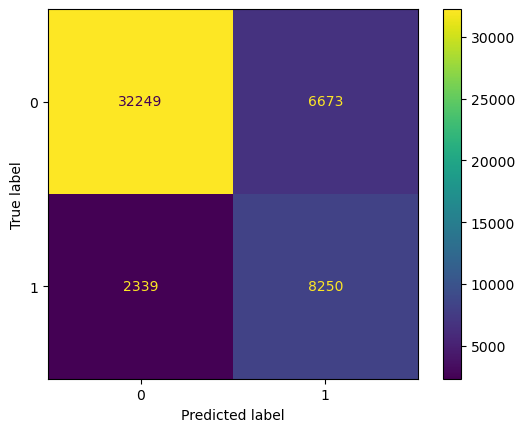

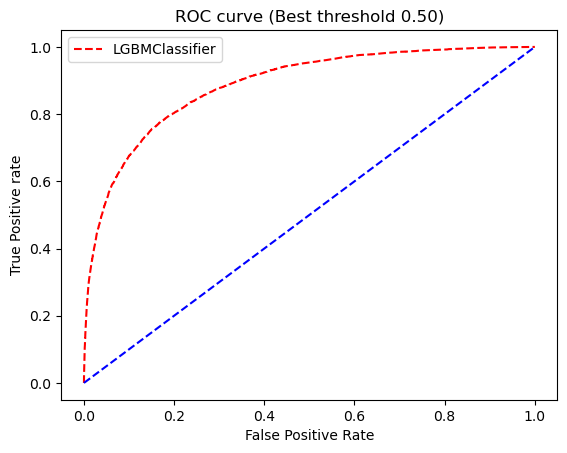

In [30]:
#best_param = rf_param.copy()
##best_param["n_estimators"] = 50
#best_param["max_depth"] = 15

#tune_model_over = RandomForestClassifier(**best_param)
tune_model_over,_ = train_a_model(top_x_over, y_over, top_x_test, y_test, tuned_lgb2)

model_evaluation(tune_model_over, top_x_test, y_test)

- Ensembling

In [ ]:
y_pred = tune_model_over.predict(top_x_test)

wrong_predictions = np.where((y_pred!=y_test))
wrong_x, wrong_y = top_x_test[wrong_predictions], y_test[wrong_predictions]

random_state = 123
models = {
            "lr": LogisticRegression(random_state=random_state),
            "knn": KNeighborsClassifier(),
            "nb": GaussianNB(),
            "dt": DecisionTreeClassifier(random_state=random_state),
            "mlp": MLPClassifier(random_state=random_state),
            "qda": QuadraticDiscriminantAnalysis(),
            "ada": AdaBoostClassifier(random_state=random_state),
            "gbc": GradientBoostingClassifier(random_state=random_state),
            "lda": LinearDiscriminantAnalysis(),
            "et": ExtraTreesClassifier(random_state=random_state),
            "xgboost": XGBClassifier(
                random_state=random_state,
            ),
            "lgbm": LGBMClassifier(random_state=random_state),
        }
for key, model in models.items():
    model.fit(top_sample_x, sample_y)
    y_p = model.predict(wrong_x)
    accuracy = accuracy_score(wrong_y, y_p)
    auc = roc_auc_score(wrong_y, y_p, average="weighted")
    print("{}: Accuracy = {:.3f} AUC = {:.3f}".format(
        key, accuracy, auc))


lr: Accuracy = 0.185 AUC = 0.196
knn: Accuracy = 0.378 AUC = 0.316
nb: Accuracy = 0.300 AUC = 0.485
dt: Accuracy = 0.464 AUC = 0.363


C:\Users\mapmxj\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mapmxj\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


mlp: Accuracy = 0.272 AUC = 0.237
qda: Accuracy = 0.282 AUC = 0.488
ada: Accuracy = 0.212 AUC = 0.173
gbc: Accuracy = 0.238 AUC = 0.180
lda: Accuracy = 0.180 AUC = 0.194
et: Accuracy = 0.474 AUC = 0.375
xgboost: Accuracy = 0.414 AUC = 0.306
lgbm: Accuracy = 0.394 AUC = 0.295


In [32]:
from sklearn.ensemble import VotingClassifier

random_state = 123

models = {
    "lr": LogisticRegression(random_state=random_state),
    "knn": KNeighborsClassifier(),
    "nb": GaussianNB(),
    "et": ExtraTreesClassifier(random_state=random_state, n_estimators=10,max_depth=1
    ),
    "mlp": MLPClassifier(random_state=random_state),
    "qda": QuadraticDiscriminantAnalysis(),
    "lda": LinearDiscriminantAnalysis(),
    "ada": AdaBoostClassifier(random_state=random_state),
    "gbc": GradientBoostingClassifier(random_state=random_state),
    "rf": RandomForestClassifier(**rf_param),
    'lgbml': LGBMClassifier(**lgb_param)
}

ensemble_models = {}
keys = list(models.keys())
model1 = tune_model_over
for i in range(len(models) - 1):
    model2 = keys[i]
    ensemble_models["base_{}".format(model2)] = VotingClassifier(
            estimators=[('base', model1), 
                        (model2, models[model2])],
            voting="soft",
            weights=[0.8, 0.2]
        )

ensemble = compare_models(
    top_sample_x, sample_y,
    ensemble_models)


base_lr	Accuracy: 0.85	AUC: 0.85	Recall: 0.85	Precision: 0.85	F1-Score: 0.85	Kappa: 0.69	MCC: 0.69	Log Loss: 0.41	Training Time: 0.51	
base_knn	Accuracy: 0.87	AUC: 0.87	Recall: 0.87	Precision: 0.87	F1-Score: 0.87	Kappa: 0.74	MCC: 0.74	Log Loss: 0.36	Training Time: 0.52	
base_nb	Accuracy: 0.66	AUC: 0.66	Recall: 0.66	Precision: 0.78	F1-Score: 0.62	Kappa: 0.33	MCC: 0.43	Log Loss: 0.53	Training Time: 0.48	
base_et	Accuracy: 0.86	AUC: 0.86	Recall: 0.86	Precision: 0.86	F1-Score: 0.86	Kappa: 0.71	MCC: 0.71	Log Loss: 0.47	Training Time: 0.48	
base_mlp	Accuracy: 0.87	AUC: 0.87	Recall: 0.87	Precision: 0.87	F1-Score: 0.87	Kappa: 0.74	MCC: 0.74	Log Loss: 0.37	Training Time: 1.28	
base_qda	Accuracy: 0.66	AUC: 0.66	Recall: 0.66	Precision: 0.79	F1-Score: 0.62	Kappa: 0.32	MCC: 0.43	Log Loss: 0.53	Training Time: 0.52	
base_lda	Accuracy: 0.85	AUC: 0.85	Recall: 0.85	Precision: 0.85	F1-Score: 0.85	Kappa: 0.70	MCC: 0.70	Log Loss: 0.40	Training Time: 0.53	
base_ada	Accuracy: 0.87	AUC: 0.87	Recall: 0.87	Prec

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,Log Loss,Training Time
8,base_gbc,0.879091,0.879080,0.879091,0.880391,0.878995,0.758180,0.759478,0.349752,0.657100
9,base_rf,0.875315,0.875295,0.875315,0.876818,0.875218,0.750625,0.752126,0.354659,0.863922
1,base_knn,0.869679,0.869674,0.869679,0.871528,0.869548,0.739353,0.741199,0.357443,0.517176
4,base_mlp,0.868431,0.868447,0.868431,0.870224,0.868298,0.736868,0.738652,0.369548,1.275070
7,base_ada,0.871573,0.871568,0.871573,0.872592,0.871494,0.743148,0.744164,0.490747,0.576153
6,base_lda,0.850268,0.850275,0.850268,0.852263,0.850073,0.700540,0.702527,0.401213,0.528308
3,base_et,0.856526,0.856529,0.856526,0.857852,0.856397,0.713059,0.714378,0.474605,0.481545
0,base_lr,0.846505,0.846509,0.846505,0.848254,0.846337,0.693012,0.694755,0.410269,0.513628
2,base_nb,0.663531,0.663518,0.663531,0.784958,0.623019,0.327020,0.431418,0.530584,0.480521
5,base_qda,0.660400,0.660362,0.660400,0.789559,0.617330,0.320704,0.430336,0.533254,0.515743


In [33]:
best_estimators = ensemble.get_params()['estimators']
ensemble_models = {
    "90_10": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.9, 0.1]
        ),
    "80_20": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.8, 0.2]
        ),
    "70_30": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.7, 0.3]
        ),
    "60-40": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.6, 0.4]
        ),
    "95_05": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.95, 0.05]
        ),
    "50_50": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.5, 0.5]
        ),
}
ensemble = compare_models(
    top_sample_x, sample_y,
    ensemble_models)

90_10	Accuracy: 0.87	AUC: 0.87	Recall: 0.87	Precision: 0.87	F1-Score: 0.87	Kappa: 0.75	MCC: 0.75	Log Loss: 0.39	Training Time: 0.68	
80_20	Accuracy: 0.88	AUC: 0.88	Recall: 0.88	Precision: 0.88	F1-Score: 0.88	Kappa: 0.76	MCC: 0.76	Log Loss: 0.38	Training Time: 0.65	
70_30	Accuracy: 0.88	AUC: 0.88	Recall: 0.88	Precision: 0.88	F1-Score: 0.88	Kappa: 0.76	MCC: 0.76	Log Loss: 0.36	Training Time: 0.67	
60-40	Accuracy: 0.88	AUC: 0.88	Recall: 0.88	Precision: 0.88	F1-Score: 0.88	Kappa: 0.76	MCC: 0.76	Log Loss: 0.35	Training Time: 0.66	
95_05	Accuracy: 0.87	AUC: 0.87	Recall: 0.87	Precision: 0.87	F1-Score: 0.87	Kappa: 0.74	MCC: 0.75	Log Loss: 0.40	Training Time: 0.64	
50_50	Accuracy: 0.88	AUC: 0.88	Recall: 0.88	Precision: 0.88	F1-Score: 0.88	Kappa: 0.76	MCC: 0.77	Log Loss: 0.34	Training Time: 0.63	


,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,Log Loss,Training Time
5,50_50,0.882220,0.882213,0.882220,0.883293,0.882145,0.764438,0.765510,0.337960,0.634471
2,70_30,0.880341,0.880330,0.880341,0.881429,0.880260,0.760679,0.761767,0.361982,0.667339
3,60-40,0.878464,0.878451,0.878464,0.879794,0.878365,0.756925,0.758254,0.349721,0.657379
1,80_20,0.879087,0.879080,0.879087,0.880222,0.879007,0.758175,0.759307,0.375054,0.653139
0,90_10,0.873446,0.873439,0.873446,0.874309,0.873388,0.746893,0.747753,0.389020,0.679078
4,95_05,0.872198,0.872197,0.872198,0.873156,0.872129,0.744400,0.745354,0.396079,0.640707



*******
Results for model VotingClassifier(estimators=[('lgbml',
                              LGBMClassifier(bagging_fraction=0.5,
                                             boosting='goss', device='gpu',
                                             feature_fraction=0.5,
                                             is_unbalance=True,
                                             lambda_l1=1.1214323077269823,
                                             lambda_l2=0.005114020277529055,
                                             learning_rate=0.018, metric='auc',
                                             n_jobs=-1, objective='binary',
                                             seed=42, verbose=-1)),
                             ('xgb',
                              XGBClassifier(alpha=8.00150841553724,
                                            base_score=None, boost...
                                            importance_type=None,
                                           

,metrics,train,validation
0,Accuracy,0.84,0.83
1,AUC,0.84,0.80
2,Recall,0.84,0.83
3,Precision,0.84,0.85
4,F1-Score,0.84,0.84
5,Kappa,0.68,0.54
6,MCC,0.68,0.55
7,Log Loss,0.40,0.41
8,Training Time,10.03,10.03


              precision    recall  f1-score   support

           0       0.93      0.85      0.89     38922
           1       0.58      0.76      0.65     10589

    accuracy                           0.83     49511
   macro avg       0.75      0.80      0.77     49511
weighted avg       0.85      0.83      0.84     49511



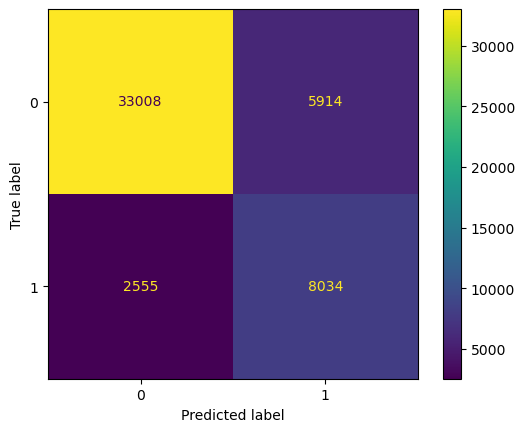

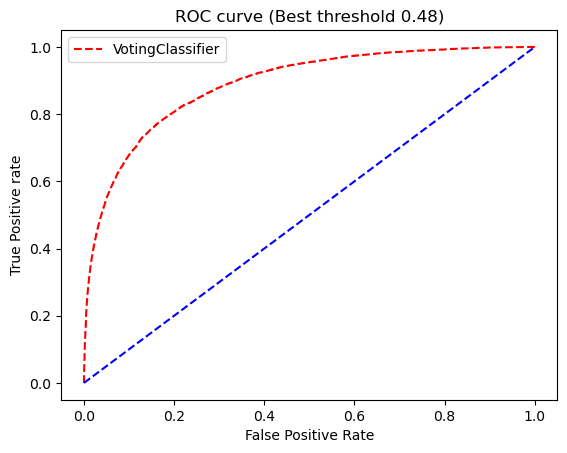

In [62]:
x_over, y_over = sampler.fit_resample(x_train, y_train)
top_x_over = x_over[:, ids]

ensemble_model, _ = train_a_model(
    top_x_over,
    y_over,
    top_x_test,
    y_test,
    ensemble,
)
model_evaluation(ensemble_model, top_x_test, y_test)

## NN model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

class Wide(nn.Module):
    def __init__(self, n_feature):
        super().__init__()
        self.hidden = nn.Linear(n_feature, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
class Deep(nn.Module):
    def __init__(self, n_feature):
        super().__init__()
        self.layer1 = nn.Linear(n_feature, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x


def over_sampling_train(x_tr, y_tr, batch_size=64):
    # Define a custom dataset class
    class CustomDataset(Dataset):
        def __init__(self, data, targets):
            self.data = data
            self.targets = targets

        def __len__(self):
            return len(self.data)

        def __getitem__(self, index):
            return self.data[index], self.targets[index]

    # Calculate class frequencies
    int_labels_tensor = torch.floor(y_tr).to(torch.int64).ravel()

    class_freq = torch.bincount(int_labels_tensor)
    class_weights = 1.0 / class_freq.float()

    # Assign weights to each sample based on its class
    weights = [class_weights[label] for label in int_labels_tensor]
    sampler = WeightedRandomSampler(weights, len(weights))

    # Create a DataLoader with the oversampled dataset
    dataset = CustomDataset(x_tr, y_tr)
    loader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    return loader


def train_my_model(
    model, loader, n_epochs=100, verbose=True, x_val_tr=None, y_val_tr=None
):
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.BCELoss()
    sum_pr_time = 0
    n_batch = 0
    res = []
    for epoch in range(n_epochs):
        model.train()
        i = 0
        start_time = time.time()
        f1 = 0
        auc = 0
        tpr = 0
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_pred = (y_pred > 0.5).int()
            f1 += f1_score(y_batch, y_pred, average="macro")
            auc += accuracy_score(y_batch, y_pred)
            i += 1
            if confusion_matrix(y_batch, y_pred).shape[0] == 2:
                _, _, fn, tp = confusion_matrix(y_batch, y_pred).ravel()
                tpr += tp / (tp + fn + 0.00009)
            loading = 0
            if n_batch != 0:
                loading = 100 * i / n_batch
            if verbose:
                print(
                    "Epoch {}: auc: {:.2f}\tf1: {:.2f}\tTPR: {:.3f}\tloss{:.2f}\
                    \t {:.2f}% ".format(
                        epoch, auc / i, f1 / i, tpr / i, loss.item(), loading
                    ),
                    end="\r",
                )
        if n_batch == 0:
            n_batch = i
        end_time = time.time()
        prt_time = end_time - start_time
        sum_pr_time += prt_time
        ave_time = sum_pr_time / (epoch + 1)
        t = int(ave_time * (n_epochs - epoch - 1))
        remaining_time = "{:02d}:{:02d}:{:02d}".format(
            t // 3600, (t // 60) % 60, t % 60
        )

        y_pred_val = 0
        loss_val = 0
        y_pred_val = 0
        f1_val = 0
        auc_val = 0
        tpr_val = 0
        if x_val_tr != None and y_val_tr != None:
            y_pred_val = model(x_val_tr)
            loss_val = loss_fn(y_pred_val, y_val_tr).item()
            y_pred_val = (y_pred_val > 0.5).int()
            f1_val = f1_score(y_val_tr, y_pred_val, average="macro")
            auc_val = accuracy_score(y_val_tr, y_pred_val)
            if confusion_matrix(y_val_tr, y_pred_val).shape[0] == 2:
                _, _, fn_val, tp_val = confusion_matrix(y_val_tr, y_pred_val).ravel()
                tpr_val = tp_val / (tp_val + fn_val + 0.00009)

        res.append(
            [
                epoch,
                auc / i,
                f1 / i,
                tpr / i,
                loss.item(),
                auc_val,
                f1_val,
                tpr_val,
                loss_val,
            ]
        )
        if verbose:
            verbos_format = (
                "Epoch {}: auc: {:.2f}\tf1: {:.2f}\tTPR: {:.3f}"
                + "\tloss{:.2f}\tend in {}\tval_auc: {:.2f}\tval_f1: {:.2f}"
                + "\tTPR: {:.3f}\tloss{:.2f}"
            )
            print(
                verbos_format.format(
                    epoch,
                    auc / i,
                    f1 / i,
                    tpr / i,
                    loss.item(),
                    remaining_time,
                    auc_val,
                    f1_val,
                    tpr_val,
                    loss_val,
                )
            )

    return pd.DataFrame(
        res,
        columns=[
            "epoch",
            "accuracy",
            "f1_score",
            "true_possitive_rate",
            "loss",
            "accuracy_val",
            "f1_score_val",
            "true_possitive_rate_val",
            "loss_val",
        ],
    )

def plot_learning_curve(df, train_col, val_col):
    fig, ax = plt.subplots()

    ax.plot(df[train_col].values, label="train")
    ax.plot(df[val_col].values, label="validation")
    plt.title("Model learning curve")
    plt.xlabel("epoch")
    plt.ylabel(train_col)
    plt.legend()
    plt.show()


In [ ]:
x_train_tr = torch.tensor(x_train).float()
y_train_tr = torch.tensor(y_train.reshape(-1,1)).float()

x_test_tr = torch.tensor(x_test).float()
y_test_tr = torch.tensor(y_test.reshape(-1,1)).float()

print(x_train_tr.shape)
print(y_train_tr.shape)

torch.Size([115523, 53])
torch.Size([115523, 1])


In [ ]:
batch_size = 64
n_epoch = 100
deep_model = Deep(x_train_tr.shape[1])

wide_model = Wide(x_train_tr.shape[1])
loader = over_sampling_train(x_train_tr, y_train_tr, batch_size)
res = train_my_model(wide_model, loader, n_epoch, 
               x_val_tr = x_test_tr, y_val_tr = y_test_tr)


Epoch 0: auc: 0.76	f1: 0.76	TPR: 0.759	loss0.29	end in 00:16:46	val_auc: 0.78	val_f1: 0.73	TPR: 0.816	loss0.47
Epoch 1: auc: 0.80	f1: 0.80	TPR: 0.794	loss0.39	end in 00:16:43	val_auc: 0.80	val_f1: 0.75	TPR: 0.796	loss0.43
Epoch 2: auc: 0.80	f1: 0.80	TPR: 0.791	loss0.40	end in 00:17:18	val_auc: 0.82	val_f1: 0.76	TPR: 0.754	loss0.40
Epoch 3: auc: 0.80	f1: 0.80	TPR: 0.797	loss0.11	end in 00:17:37	val_auc: 0.79	val_f1: 0.74	TPR: 0.812	loss0.45
Epoch 4: auc: 0.80	f1: 0.80	TPR: 0.796	loss0.49	end in 00:18:06	val_auc: 0.80	val_f1: 0.75	TPR: 0.793	loss0.44
Epoch 5: auc: 0.81	f1: 0.80	TPR: 0.797	loss0.19	end in 00:18:10	val_auc: 0.80	val_f1: 0.75	TPR: 0.800	loss0.44
Epoch 6: auc: 0.80	f1: 0.80	TPR: 0.795	loss0.36	end in 00:18:11	val_auc: 0.81	val_f1: 0.76	TPR: 0.777	loss0.41
Epoch 7: auc: 0.81	f1: 0.81	TPR: 0.800	loss0.95	end in 00:17:51	val_auc: 0.83	val_f1: 0.77	TPR: 0.739	loss0.39
Epoch 8: auc: 0.81	f1: 0.81	TPR: 0.800	loss0.44	end in 00:17:36	val_auc: 0.80	val_f1: 0.75	TPR: 0.797	loss0.44
E

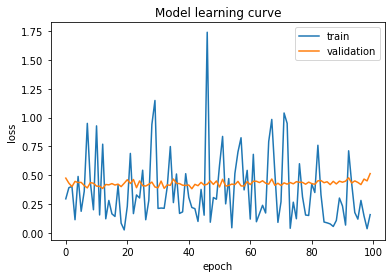

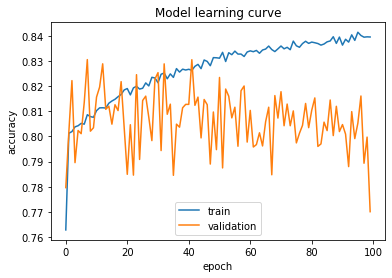

In [ ]:
plot_learning_curve(res, 'loss', 'loss_val')
plot_learning_curve(res, 'accuracy', 'accuracy_val')

## Model Production

In [40]:
filename = "..\\data\\test.csv"
test_df = pd.read_csv(filename)

test_id = test_df['id'].values
test_df.drop(['id', 'CustomerId'], axis=1, inplace=True)

abrv_name = [name[:4] for name in test_df['Surname'].values]
no_col = test_df.shape[1]
test_df.insert(no_col, 'abrv', abrv_name)
test_df.drop('Surname', axis=1, inplace=True)

credit_range = {
    'Poor Credit': [300, 579],
    'Fair Credit': [580, 669],
    'Good Credit': [670, 739],
    'Very Good Credit': [740, 799],
    'Excellent Credit': [800, 850],
}
for key, val in credit_range.items():
    group = 1*((test_df['CreditScore'].values>=val[0]) &
                 (test_df['CreditScore'].values<=val[1]))
    no_col = test_df.shape[1]
    test_df.insert(no_col, key, group)

zeroBalance = 1*(test_df['Balance']==0)

no_col = test_df.shape[1]
test_df.insert(no_col, 'zeroBalance', zeroBalance)

age_range = {
    '20-25': [20, 25],
    '25-35': [25, 35],
    '35-65': [35, 65],
    '+65': [65, 100]
}
for key, val in age_range.items():
    group = 1*((test_df['Age'].values>=val[0]) &
                 (test_df['Age'].values<=val[1]))
    no_col = test_df.shape[1]
    test_df.insert(no_col, key, group)

salary_range = {
    '<20k': [0, 20000],
    '20k-50k': [20000, 50000],
    '50k-100k': [50000, 100000],
    '100k-150k': [100000, 150000],
    '150k+': [150000, 250000]

}
for key, val in salary_range.items():
    group = 1*((test_df['EstimatedSalary'].values>=val[0]) &
                 (test_df['EstimatedSalary'].values<=val[1]))
    no_col = test_df.shape[1]
    test_df.insert(no_col, key, group)

x_t = test_df.iloc[:,:].values

features_test = test_df.columns.tolist()
col_id = features_test.index('Gender')
x_t[:,col_id] = gender_en.fit_transform(x_t[:,col_id])

encoded_x_t = np.array(one_hat_encoder.transform(x_t))

x_scaled_t = sc.transform(encoded_x_t)

feature_copy_2 = ALL_FEATURES.copy()
cols = [
 ['*', 'HasCrCard', 'IsActiveMember'],
 ['/', 'EstimatedSalary','Tenure'],
 ['/', 'NumOfProducts','Tenure'],
 ['*', 'zeroBalance','20-25'],
 ['*', 'Geography=Germany','Gender'],
 ['*', '20-25','Gender'],
]
for s, f1, f2 in cols:
        i = ALL_FEATURES.index(f1)
        j = ALL_FEATURES.index(f2)
        if s=='*':
                a = x_scaled_t[:, i] * x_scaled_t[:, j]
        else:
                a = x_scaled_t[:, i] / (0.0001+x_scaled_t[:, j])
        feature_copy_2.append("{}{}{}".format(f1, s, f2))
        x_scaled_t = np.column_stack((x_scaled_t, a))
    
print(x_scaled_t.shape)

(110023, 2030)


- random forest model

In [63]:
x_over_all, y_over_all = sampler.fit_resample(x_copy, y)
ensemble_model.fit(x_over_all[:, ids], y_over_all)

ids_test = np.where(np.in1d(feature_copy_2, top_20_feature))[0]

top_x_r = pd.DataFrame(x_scaled_t[:, ids_test], columns = np.array(feature_copy_2)[ids_test]
                   )[top_20_feature].values

y_pred_t = ensemble_model.predict_proba(top_x_r)[:,1]

pd.DataFrame({
    'id': test_id,
    'Exited':y_pred_t
}).to_csv('submission ensemble 5.csv', index=False)

c:\Users\mjafarikang\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:54:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


- Deep learning Model

In [ ]:
x_t_tr = torch.tensor(x_scaled_t).float()
y_pred_t = wide_model(x_t_tr).detach().numpy().ravel()
pd.DataFrame({
    'id': test_id,
    'Exited':y_pred_t
}).to_csv('submission wide.csv', index=False)
